# Imports

In [1]:
!pip install pandas
!pip install evaluate
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.7 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7


In [2]:
import os
import torch
import evaluate
import pandas as pd
from PIL import Image

from torch.optim import AdamW
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TrOCRProcessor, VisionEncoderDecoderModel, AutoProcessor

# Dataset

In [3]:
# Load CSV file
csv_path = "/kaggle/input/trocrdataset/dataset/data.csv"
df = pd.read_csv(csv_path)

In [4]:
df.head()

,image_file,text
0,dataset/preprocessed_images/0.png,थिए।
1,dataset/preprocessed_images/1.png,थिए। दाऊदले स्वर्गदूतले
2,dataset/preprocessed_images/2.png,२५-०५-२५-२५२६०
3,dataset/preprocessed_images/3.png,०२-०८-२२
4,dataset/preprocessed_images/4.png,पनि छोराहरू थिए।


In [5]:
# Load the processor, tokenizer, and model
processor = TrOCRProcessor.from_pretrained('/kaggle/input/part1trocr/part_1/nepali_ocr_processor', use_fast=False)

In [6]:
word = "साल: 0224 महिना: 20 गते: 987651287445! तपाईको नाम क हो ?"
word = "त्रुच्क"
word = "क्षमता"
word = "ज्ञानी"
word = "प्रकाश"
word = "ट्रक"
tokens = processor.tokenizer.tokenize(word)
print(tokens)

['▁', 'ट', '्', 'र', 'क']


In [7]:
list_nepali_digits = ['़','ँ','ं','ः','।','ृ','्',
                      'अ','आ','इ','ई','उ','ऊ','ऋ','ऌ','ए','ऐ','ओ','औ',
                      'क','ख','ग','घ','ङ','च','छ','ज','झ','ञ',
                      'ट','ठ','ड','ढ','ण','त','थ','द','ध','न',
                      'प','फ','ब','भ','म','य','र','ल','व','श','ष','स','ह',
                      'ा','ि','ी','ु','ू','े','ै','ो','ौ',
                      'ॐ','ॠ',
                      '०','१','२','३','४','५','६','७','८','९'
                     ]

print(len(list_nepali_digits))

73


In [8]:
unknown_characters = []
for i in list_nepali_digits:
    token_id = processor.tokenizer.convert_tokens_to_ids(i)
    # print(i, token_id)
    if token_id == 3:
        unknown_characters.append(i)

print(unknown_characters)
print(len(unknown_characters))

['ः', 'ऊ', 'ऋ', 'ऌ', 'ऐ', 'ङ', 'ञ', 'ॐ', 'ॠ', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९']
19


In [9]:
rare_symbols = [
    '¶', '§', '†', '‡', '‰', '¤', '¢',  '£', '¿', '∞', '∑',  '∂', '∇', '∆',
    '⌘', '≈', '≠', '¢', '¥'
]
print(len(rare_symbols))

for i in rare_symbols:
    token_id = processor.tokenizer.convert_tokens_to_ids(i)
    print(i, token_id)

19
¶ 62875
§ 62919
† 62825
‡ 63209
‰ 63463
¤ 63210
¢ 36728
£ 37118
¿ 60576
∞ 63051
∑ 63542
∂ 63043
∇ 63785
∆ 63574
⌘ 63271
≈ 62835
≠ 63384
¢ 36728
¥ 63254


In [10]:
token = processor.tokenizer.convert_ids_to_tokens(63254)
token

'¥'

In [11]:
nepali_to_english = {}
for i in range(19):
    nepali_to_english[unknown_characters[i]] = rare_symbols[i]

nepali_to_english

{'ः': '¶',
 'ऊ': '§',
 'ऋ': '†',
 'ऌ': '‡',
 'ऐ': '‰',
 'ङ': '¤',
 'ञ': '¢',
 'ॐ': '£',
 'ॠ': '¿',
 '०': '∞',
 '१': '∑',
 '२': '∂',
 '३': '∇',
 '४': '∆',
 '५': '⌘',
 '६': '≈',
 '७': '≠',
 '८': '¢',
 '९': '¥'}

In [12]:
# Replace Nepali digits with English digits in the 'text' column
df['text'] = df['text'].replace(nepali_to_english, regex=True)

In [13]:
df.head()

,image_file,text
0,dataset/preprocessed_images/0.png,थिए।
1,dataset/preprocessed_images/1.png,थिए। दा§दले स्वर्गदूतले
2,dataset/preprocessed_images/2.png,∂⌘-∞⌘-∂⌘-∂⌘∂≈∞
3,dataset/preprocessed_images/3.png,∞∂-∞¢-∂∂
4,dataset/preprocessed_images/4.png,पनि छोराहरू थिए।


In [14]:
train_df, test_df = train_test_split(df, test_size=0.2)

# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Preprocessing

In [15]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['image_file'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [16]:
train_dataset = IAMDataset(root_dir='/kaggle/input/trocrdataset/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/kaggle/input/trocrdataset/',
                           df=test_df,
                           processor=processor)

In [17]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 56000
Number of validation examples: 14000


In [18]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


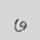

In [19]:
image = Image.open(train_dataset.root_dir + train_df['image_file'][0]).convert("RGB")
image

In [20]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

≠


In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

# Training

In [22]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
model = VisionEncoderDecoderModel.from_pretrained('/kaggle/input/part1trocr/part_1/nepali_ocr_model')
model.to(device)

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 1024,
  "decode

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense):

In [24]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [25]:
cer_metric = evaluate.load("cer")

In [26]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [27]:
optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(7):
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer 

   print("Validation CER:", valid_cer / len(eval_dataloader))

model.save_pretrained(".")  

  0%|          | 0/14000 [00:00<?, ?it/s]

Loss after epoch 0: 0.06593588283001763


  0%|          | 0/3500 [00:00<?, ?it/s]

Validation CER: 0.022283407600626075


  0%|          | 0/14000 [00:00<?, ?it/s]

Loss after epoch 1: 0.04688607117116174


  0%|          | 0/3500 [00:00<?, ?it/s]

Validation CER: 0.03139663704001885


  0%|          | 0/14000 [00:00<?, ?it/s]

Loss after epoch 2: 0.03814596338167764


  0%|          | 0/3500 [00:00<?, ?it/s]

Validation CER: 0.03297855941373875


  0%|          | 0/14000 [00:00<?, ?it/s]

Loss after epoch 3: 0.03227427803544989


  0%|          | 0/3500 [00:00<?, ?it/s]

Validation CER: 0.021407020805108853


  0%|          | 0/14000 [00:00<?, ?it/s]

Loss after epoch 4: 0.026099405693073226


  0%|          | 0/3500 [00:00<?, ?it/s]

Validation CER: 0.01539891251437448


  0%|          | 0/14000 [00:00<?, ?it/s]

Loss after epoch 5: 0.02400581935504189


  0%|          | 0/3500 [00:00<?, ?it/s]

Validation CER: 0.01787512442461128


  0%|          | 0/14000 [00:00<?, ?it/s]

Loss after epoch 6: 0.02102284741922813


  0%|          | 0/3500 [00:00<?, ?it/s]

Validation CER: 0.018541246120973836


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


In [28]:
model.save_pretrained("/kaggle/working/model/part_7/nepali_ocr_model")
processor.save_pretrained("/kaggle/working/model/part_7/nepali_ocr_processor")

[]